<a href="https://colab.research.google.com/github/Andrew-TraverseMT/placekey-joins/blob/main/CMS_hopital_and_payment_join.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring The Relationship between Payments and Hospital Overall Ratings by Joining CMS Data with Placekey

In the context of CMS (Centers for Medicare & Medicaid Services) data, the overall hospital rating represents a summary measure of the quality of care provided by a hospital. This rating is part of the CMS Hospital Compare program, which aims to provide consumers with information to make informed decisions about healthcare. Here, we join hospital overall ratings data with payments data to explore how strongly the payments for various services correspond to the overall rating. The join is facilitated by Placekey.

### Environment Setup to Read from Drive

> Using awscli, we can pull in the skinny mappings from s3



In [ ]:
!pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.1.3 requires docutils<0.22,>=0.20, but you have docutils 0.16 which is incompatible.


In [ ]:
# download hospital payment data from CMS - includes payment and hospital lat/long for mapping
!aws s3 --no-sign-request cp s3://placekey-free-datasets/hospital-payment-value-data-from-cms/csv/hospital-payment-value-data-from-cms.csv /content/data/

download: s3://placekey-free-datasets/hospital-payment-value-data-from-cms/csv/hospital-payment-value-data-from-cms.csv to data/hospital-payment-value-data-from-cms.csv


In [ ]:
# download hospital data from CMS - includes hospital overall ranking
!aws s3 --no-sign-request cp s3://placekey-free-datasets/hospital-data-from-cms/csv/hospital-data-from-cms.csv /content/data/

download: s3://placekey-free-datasets/hospital-data-from-cms/csv/hospital-data-from-cms.csv to data/hospital-data-from-cms.csv


### Diving into the Join

> At this point, you have both files to begin the join `/content/data/hospital-payment-value-data-from-cms.csv` and `/content/data/hospital-data-from-cms.csv`

### Joining the Values
> Now, we can complete the join. Here we are joining hospital payment value data from CMS (left) to hospital data from CMS (right).

In [ ]:
import pandas as pd

payments = pd.read_csv('/content/data/hospital-payment-value-data-from-cms.csv')

hospital = pd.read_csv('/content/data/hospital-data-from-cms.csv')

In [ ]:
joined_df = pd.merge(payments, hospital, on='placekey', how='left')

> Lets explore the join for insights

In [ ]:
# Calculate the number of rows in the original payments DataFrame
payments_count = len(payments)
print(f"Number of rows in payments DataFrame: {payments_count}")

# Calculate the number of rows in the original hospital DataFrame
hospital_count = len(hospital)
print(f"Number of rows in hospital DataFrame: {hospital_count}")

# Calculate the number of rows in the joined DataFrame
joined_count = len(joined_df)
print(f"Number of rows in joined DataFrame: {joined_count}")

# Calculate the number of rows in the joined DataFrame where 'hospital_overall_rating' is not null
matched_count = joined_df['Hospital overall rating'].notna().sum()
print(f"Number of matched rows (where hospital_overall_rating is not null): {matched_count}")

# Calculate the number of rows in the payments dataframe that did not have a match in hospital data
unmatched_count = payments_count - matched_count
print(f"Number of unmatched rows from payments DataFrame: {unmatched_count}")

# Calculate the percentage of rows that were matched
match_percentage = (matched_count / payments_count) * 100 if payments_count > 0 else 0
print(f"Percentage of matched rows: {match_percentage:.2f}%")

# Calculate the percentage of rows that were not matched
unmatch_percentage = (unmatched_count / payments_count) * 100 if payments_count > 0 else 0
print(f"Percentage of unmatched rows: {unmatch_percentage:.2f}%")

# Check for duplicate placekeys in the joined dataframe.
duplicate_placekeys_count = joined_df.duplicated(subset=['placekey']).sum()
print(f"Number of duplicate placekeys in the joined dataframe: {duplicate_placekeys_count}")

print("\nNote: there are three duplicate entries for each hospital, as there are four payments metrics per hospital.")

# Group by 'placekey' and get the first 'Hospital overall rating' for each group
unique_ratings = joined_df.groupby('placekey')['Hospital overall rating'].first()

# Count hospitals in the joined dataset by isolating unique placekeys
unique_hospital_count = len(unique_ratings)
print(f"Number of unique hospitals in the joined dataset: {unique_hospital_count}")

# Calculate value counts for the unique ratings
rating_counts = unique_ratings.value_counts(dropna=False)

# Display the results
print("\nValue counts for Hospital overall rating (unique placekeys):")
print(rating_counts)

# Calculate descriptive statistics for the unique ratings
rating_distribution = unique_ratings.describe()

# Display the results
print("\nDistribution of Hospital overall rating (unique placekeys):")
print(rating_distribution)


Number of rows in payments DataFrame: 18290
Number of rows in hospital DataFrame: 5425
Number of rows in joined DataFrame: 18302
Number of matched rows (where hospital_overall_rating is not null): 13486
Number of unmatched rows from payments DataFrame: 4804
Percentage of matched rows: 73.73%
Percentage of unmatched rows: 26.27%
Number of duplicate placekeys in the joined dataframe: 13731

Note: there are three duplicate entries for each hospital, as there are four payments metrics per hospital.
Number of unique hospitals in the joined dataset: 4571

Value counts for Hospital overall rating (unique placekeys):
Hospital overall rating
Not Available    1301
None             1203
3                 602
4                 537
2                 439
5                 316
1                 173
Name: count, dtype: int64

Distribution of Hospital overall rating (unique placekeys):
count              3368
unique                6
top       Not Available
freq               1301
Name: Hospital overall

### Exploring the relationship between hospital overall rating and payments

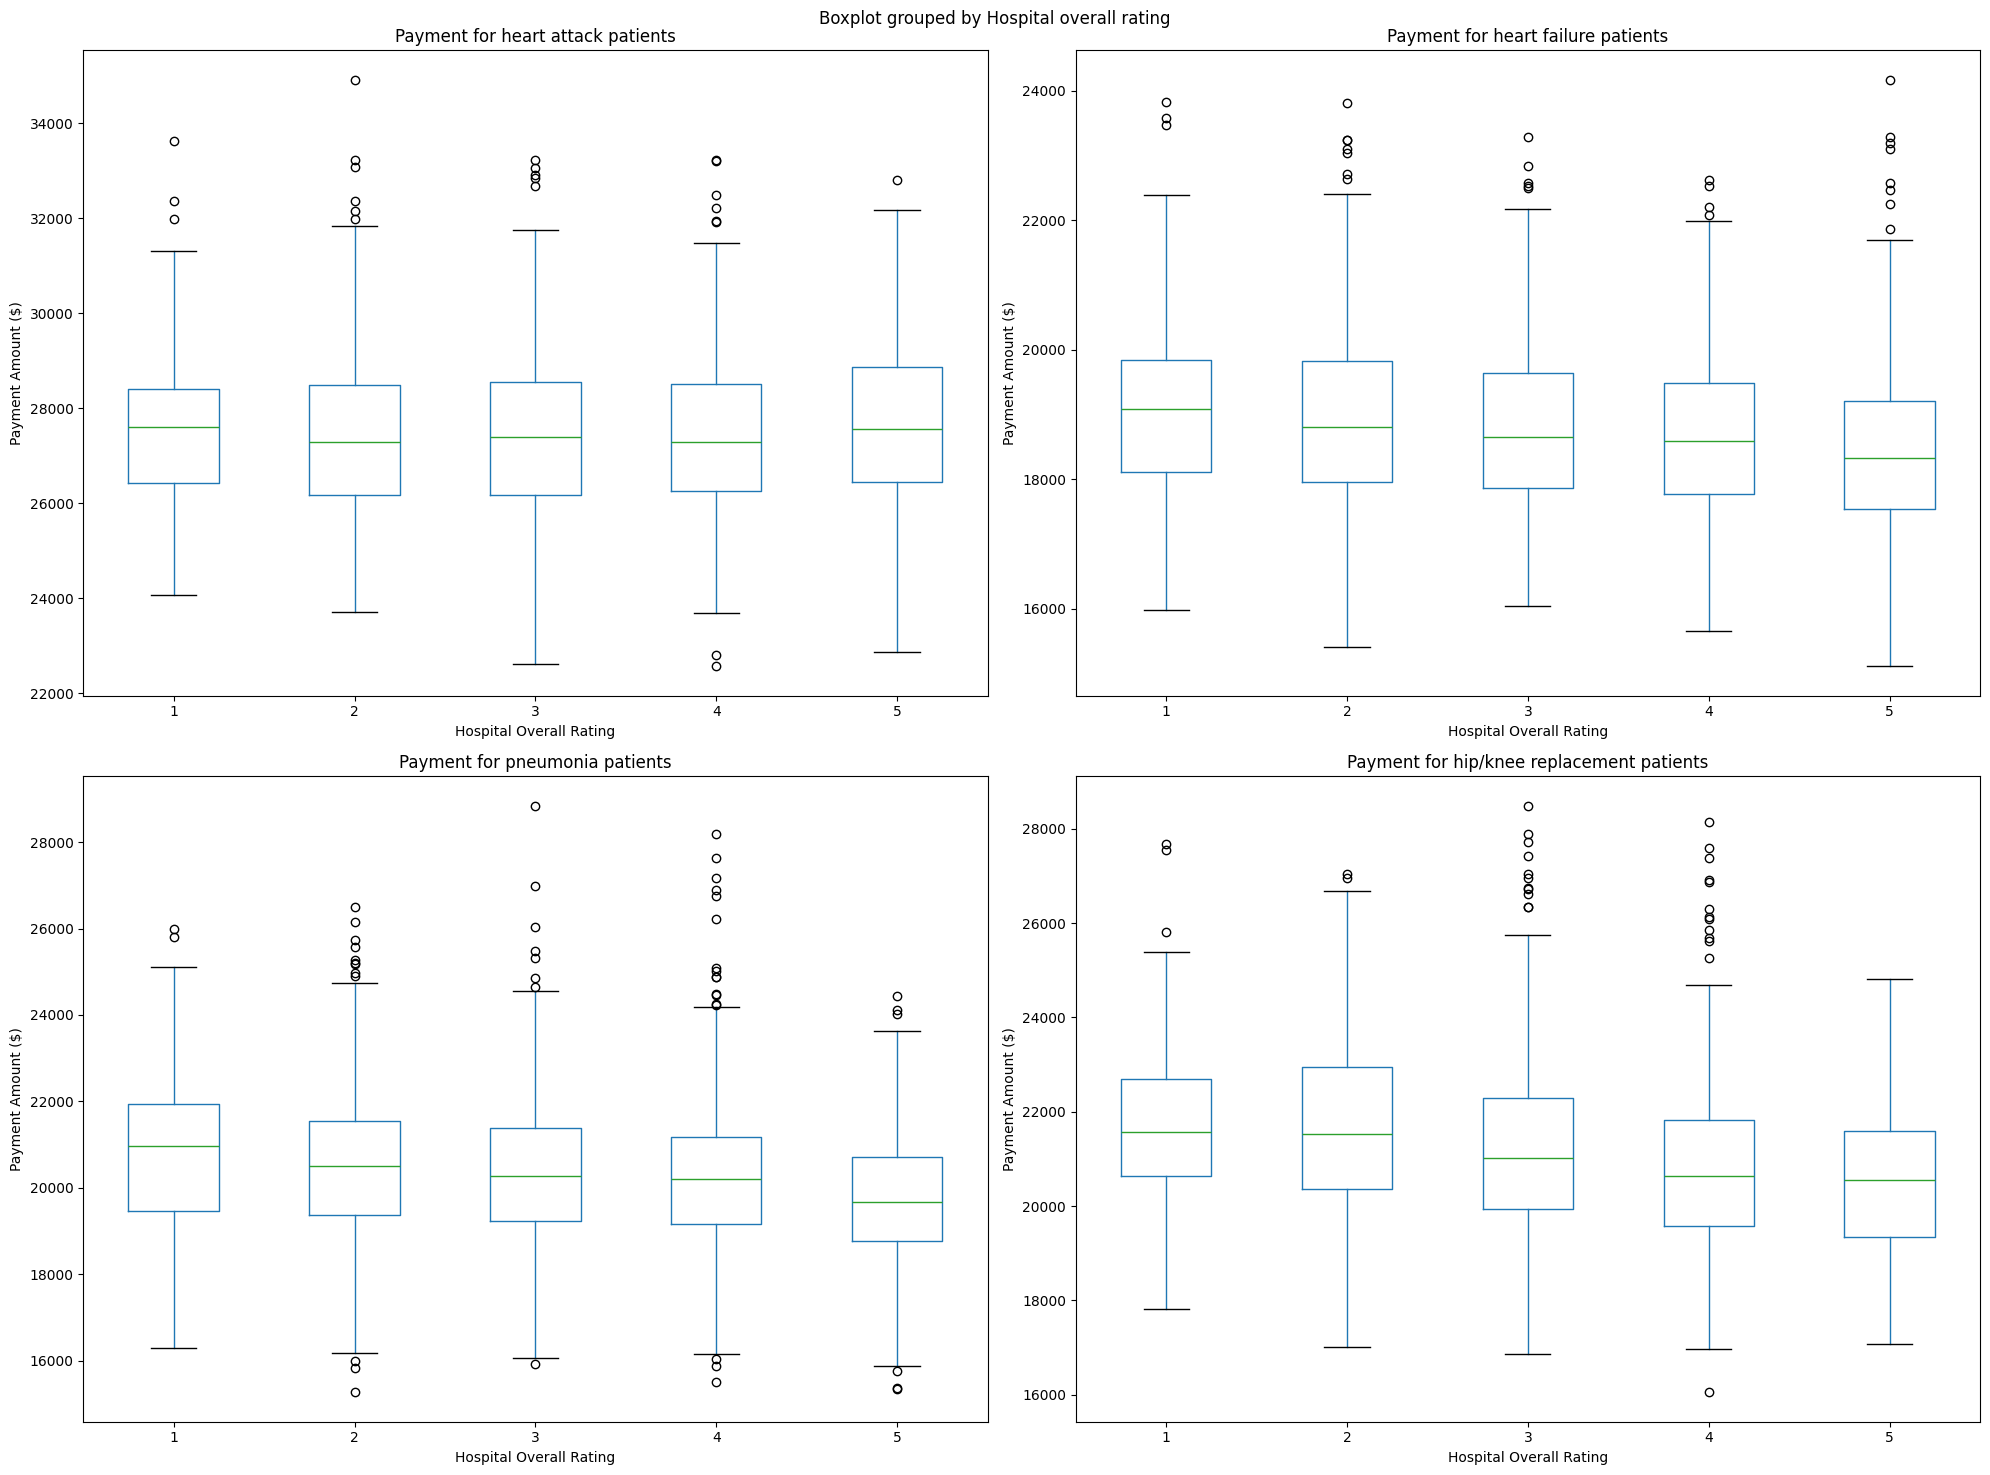

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Preprocess the 'Payment' column
joined_df['Payment'] = joined_df['Payment'].apply(lambda x: 0 if x == 'Not Available' else float(x.replace('$', '').replace(',', '')))

# Drop rows where 'Hospital overall rating' is "Not Available" or null
df_cleaned = joined_df[joined_df['Hospital overall rating'] != 'Not Available'].dropna(subset=['Hospital overall rating'])

# Convert 'Hospital overall rating' to numeric if it's not already
df_cleaned['Hospital overall rating'] = pd.to_numeric(df_cleaned['Hospital overall rating'], errors='coerce')

# Drop any new NaN values that might have been introduced by conversion
df_cleaned = df_cleaned.dropna(subset=['Hospital overall rating'])

# Exclude payment values of zero
df_cleaned = df_cleaned[df_cleaned['Payment'] != 0]

# Get unique payment measure names
unique_measures = df_cleaned['Payment Measure Name'].unique()

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Box Plots of Payments by Hospital Overall Rating for Different Payment Measures', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Loop through each unique payment measure
for i, measure in enumerate(unique_measures):
    # Filter the DataFrame for the current measure
    measure_df = df_cleaned[df_cleaned['Payment Measure Name'] == measure]

    # Plot the box plot
    measure_df.boxplot(column='Payment', by='Hospital overall rating', ax=axes[i], grid=False)

    # Set title for each subplot
    axes[i].set_title(measure)
    axes[i].set_xlabel('Hospital Overall Rating')
    axes[i].set_ylabel('Payment Amount ($)')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Preparing data for mapping

In [ ]:
# Convert to float where necessary
joined_df['geocode_latitude'] = joined_df['geocode_latitude'].astype(float)
joined_df['geocode_longitude'] = joined_df['geocode_longitude'].astype(float)
# Select relevant columns for mapping
map_data = joined_df[['Address_x', 'City/Town_x', 'State_x', 'ZIP Code_x', 'geocode_latitude', 'geocode_longitude', 'Hospital overall rating', 'Payment', 'Facility Name_x']]
map_data = map_data.drop_duplicates(subset=['Facility Name_x'])

In [ ]:
import geopandas as gpd

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    map_data,
    geometry=gpd.points_from_xy(map_data['geocode_longitude'], map_data['geocode_latitude'])
)
# Set the coordinate reference system (CRS) to WGS84, which is standard for latitude and longitude
gdf.crs = 'EPSG:4326'

### Mapping Hospital Overall Rating with Folium

In [ ]:
import folium

# Create a base map centered around the mean of your data points
map_center = [gdf['geometry'].y.mean(), gdf['geometry'].x.mean()]
attr='&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> &copy; <a href="http://cartodb.com/attributions">CartoDB</a>'
m = folium.Map(location=map_center, zoom_start=4, tiles='cartodbpositron', attr=attr)

In [ ]:
# Define color for each rating string
color_dict = {
    "1": "red",
    "2": "orange",
    "3": "yellow",
    "4": "lightgreen",
    "5": "green"
}
# Plotting each point
for idx, row in gdf.iterrows():
    # Get the color based on the rating string
    color = color_dict.get(row['Hospital overall rating'], 'grey')  # Default color if rating not in dict

    # Add circle marker with color based on rating
    folium.CircleMarker(
        location=[row['geometry'].y, row['geometry'].x],
        radius=4,  # Adjust size as needed
        color=color,  # Border color
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Hospital Rating: {row['Hospital overall rating']}<br> Facility Name: {row['Facility Name_x']}"
    ).add_to(m)
# Add a legend or color scale explanation (manually for simplicity)
legend_html = '''
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 150px; height: 150px;
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color:white; opacity: 0.8;">
         <b>Hospital Rating</b><br>
         <i style="background:green;">    </i> 5 - Excellent<br>
         <i style="background:lightgreen;">    </i> 4 - Good<br>
         <i style="background:yellow;">    </i> 3 - Average<br>
         <i style="background:orange;">    </i> 2 - Below Average<br>
         <i style="background:red;">    </i> 1 - Poor<br>
         <i style="background:grey;">    </i> Not Available<br>
    </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
# Display the map
m

In [ ]:
# Optionally, save the map as an html file to add it to a website
m.save('map.html')